## Read the json and get a pandas df

Processing JSON Data: 100%|██████████| 10000/10000 [00:00<00:00, 39116.74it/s]

(1013, 11)


,id,title,keywords,year,n_citation,abstract,doc_type,references,author_ids,author_names,author_orgs
925,53e9978ab7602d9701f458a3,Crescando,"[parallel database, strict response time, pred...",2010,19,"This demonstration presents Crescando, an impl...",Conference,"[53e9a114b7602d9702a06cce, 53e9aed1b7602d97038...","[53f438ccdabfaeb22f4882b5, 53f43241dabfaeb1a7b...","[Georgios Giannikis, Philipp Unterbrunner, Jer...",[Systems Group|Department of Computer Science|...
989,53e99796b7602d9701f5cc1c,Generalized discontinuity,"[finite number, sequence logic, segmented stri...",2010,14,We define and study a calculus of discontinuit...,Conference,"[53e99796b7602d9701f5cc1c, 53e997aeb7602d9701f...","[54486f80dabfae87b7e237b3, 53f43813dabfaee02ac...","[Glyn Morrill, Oriol Valentín]",[Departament de Llenguatges i Sistemes Informà...
987,53e99796b7602d9701f5c857,Gesture controllers,"[data-driven animation, speech signal, optimal...",2010,168,"We introduce gesture controllers, a method for...",Journal,"[53e997bab7602d9701fa382f, 53e99d0bb7602d97025...","[616798e06750f82aae3ca2d2, 53f4589ddabfaedd74e...","[Sergey Levine, Philipp Krähenbühl, Sebastian ...","[Stanford University, Stanford University, Sta..."
986,53e99796b7602d9701f5c856,Grammar constraints,"[Constraint filtering, Global constraints, Gra...",2010,15,With the introduction of the Regular Membershi...,Journal,"[557e8370f6678c77ea22371c, 53e99800b7602d97020...","[53f4425ddabfaee43ec704a8, 53f4301ddabfaedf435...","[Serdar Kadioglu, Meinolf Sellmann]","[Department of Computer Science, Brown Univers..."
985,53e99796b7602d9701f5c24a,Improved likelihood ratio test based voice act...,"[voice activity detector, robust speech recogn...",2010,25,"Nowadays, the accuracy of speech processing sy...",Journal,"[5583e6670cf2b21478ede7e2, 53e99c91b7602d97025...","[54857039dabfae8a11fb2976, 53f80867dabfae7f97a...","[J. M. Górriz, J. Ramírez, E. W. Lang, C. G. P...","[Dpt. Signal Theory, Networking and Communicat..."


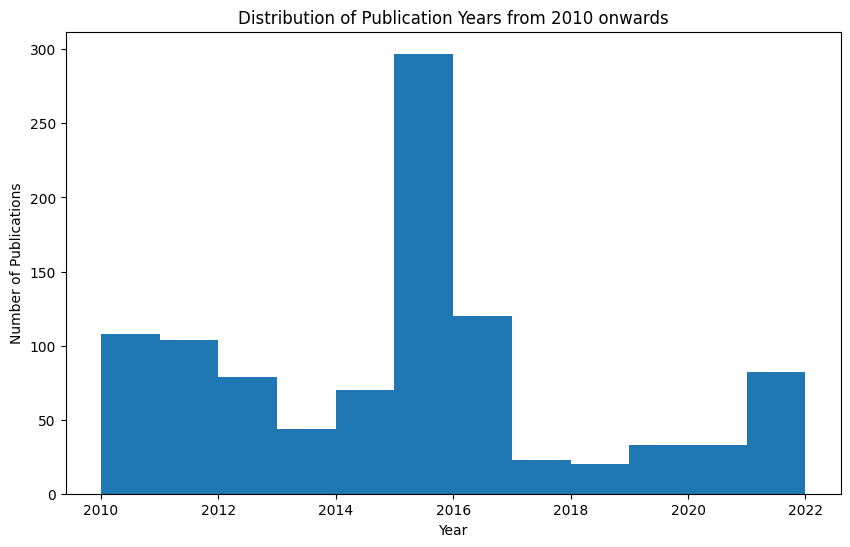

In [57]:
import ijson
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

file_path = 'Data/dblp_v14.json'

# Keys to extract from the JSON file
keys_to_extract = ['id', 'title', 'keywords', 'year', 'n_citation', 'abstract', 'authors', 'doc_type', 'references']

# Function to extract and rename fields from authors
def extract_author_fields(authors_list):
    if not authors_list:
        return None, None, None
    author_ids = []
    author_names = []
    author_orgs = []
    for author in authors_list:
        author_ids.append(author.get('id', None))
        author_names.append(author.get('name', None))
        author_orgs.append(author.get('org', None))
    return author_ids, author_names, author_orgs

# Open the JSON file
with open(file_path, 'r') as f:
    # Iterate over objects in the JSON file
    objects = ijson.items(f, 'item')
    
    # Read only the first N objects
    N = 10000
    partial_data = []
    for _, obj in tqdm(zip(range(N), objects), total=N, desc="Processing JSON Data"):
        filtered_obj = {k: obj[k] for k in keys_to_extract if k in obj}
        
        if 'year' in filtered_obj and filtered_obj['year'] >= 2010:
            
            if 'references' in filtered_obj and len(filtered_obj['references']) > 1:
            
                if 'authors' in filtered_obj:
                    author_ids, author_names, author_orgs = extract_author_fields(filtered_obj['authors'])
                    filtered_obj['author_ids'] = author_ids if author_ids else None
                    filtered_obj['author_names'] = author_names if author_names else None
                    filtered_obj['author_orgs'] = author_orgs if author_orgs else None
                    del filtered_obj['authors']
                
                partial_data.append(filtered_obj)

# Create a DataFrame from partial_data
df = pd.DataFrame(partial_data).sort_values(by='year', ascending=True)

# Example usage of the DataFrame
print(df.shape)
display(df.head())

# Save the DataFrame to a CSV file
# df.to_csv('processed_data.csv', index=False)

import matplotlib.pyplot as plt

# Create a histogram of the distribution of years
plt.figure(figsize=(10, 6))
df['year'].dropna().astype(int).hist(bins=12)
plt.title('Distribution of Publication Years from 2010 onwards')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(False)
plt.show()

## Features

In [58]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel

# Determine the device to use
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f'Using device: {device}')

# Load pretrained Sentence-BERT model and move it to the device
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_model.to(device)

# Merge title, abstract, and keywords into a single text field
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')
df['keywords'] = df['keywords'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
df['text'] = df['title'] + '. ' + df['abstract'] + '. ' + df['keywords']

# Compute Sentence-BERT embeddings for df['text']
embeddings_text = []
for text in tqdm(df['text'], desc="Processing texts"):
    embedding = sbert_model.encode(text, device=device)
    embeddings_text.append(embedding)

text_embeddings = np.vstack(embeddings_text)
print(f'Text Embeddings shape: {text_embeddings.shape}')

# Map doc_type to -1 (Conference) and 1 (Journal)
df['doc_type'] = df['doc_type'].map({'Conference': -1, 'Journal': 1})

# The remaining part uses the original BERT model

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Function to get BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Merge author information into a single field and compute BERT embeddings
df['author_ids'] = df['author_ids'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
df['author_names'] = df['author_names'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
df['author_orgs'] = df['author_orgs'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
df['author_info'] = df['author_ids'] + '. ' + df['author_names'] + '. ' + df['author_orgs']
embeddings_author = []
for text in tqdm(df['author_info'], desc="Processing authors"):
    embedding = get_bert_embeddings(text)
    embeddings_author.append(embedding)
author_embeddings = np.vstack(embeddings_author)
print(f'Author Embeddings shape: {author_embeddings.shape}')

Using device: mps


/Users/andrea/miniforge3/envs/dygnn/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing texts: 100%|██████████| 1013/1013 [00:08<00:00, 125.55it/s]


Text Embeddings shape: (1013, 384)


Processing authors: 100%|██████████| 1013/1013 [00:10<00:00, 94.13it/s] 

Author Embeddings shape: (1013, 768)


## Edge index

Creating Graph: 100%|██████████| 5749/5749 [00:00<00:00, 37492.35it/s]


Edge Index Tensor shape:
 torch.Size([2, 75029])


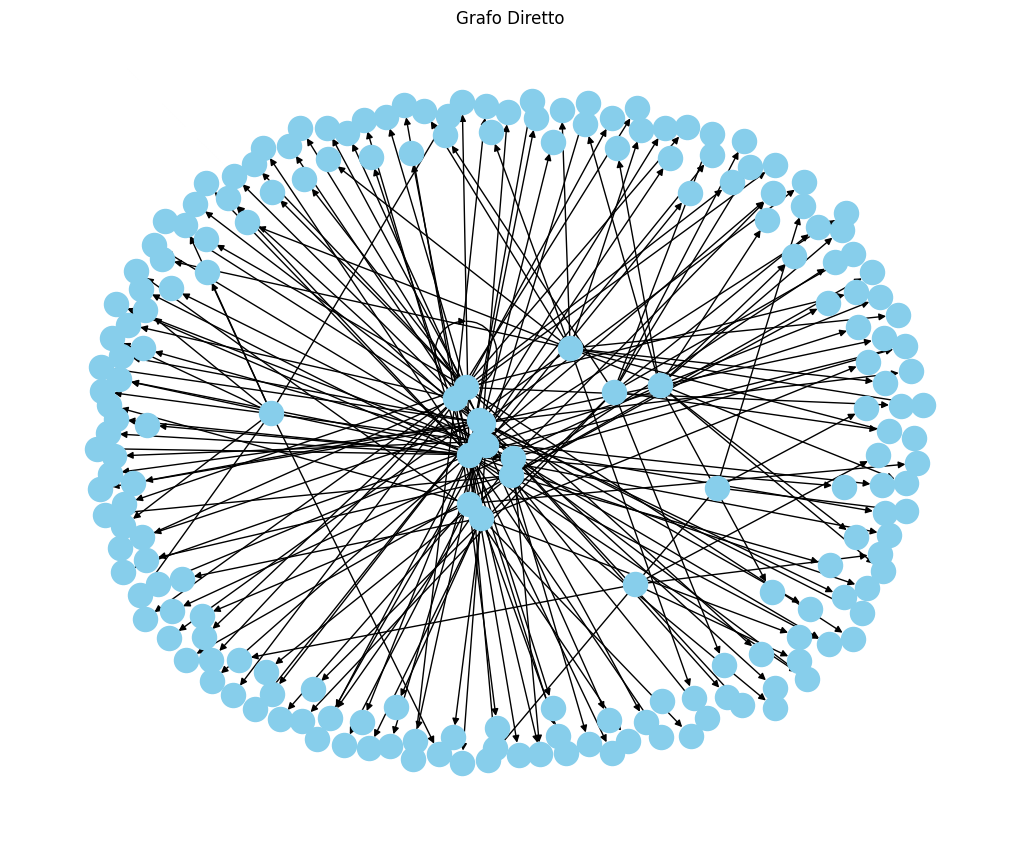

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create a directed graph from the references
G = nx.DiGraph()
for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Creating Graph"):
    node = row['id']
    references = row['references']
    for ref in references:
        G.add_edge(node, ref)

# Get the adjacency matrix and edge index tensor
adj_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
edge_index = torch.tensor(np.vstack(np.nonzero(adj_matrix)), dtype=torch.long)

# Stampa dell'edge index in formato tensore
print("Edge Index Tensor shape:\n", edge_index.shape)

# Disegnare il grafo
subgraph_nodes = list(G.nodes())[:200]
G_sub = G.subgraph(subgraph_nodes)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_sub)
nx.draw(G_sub, pos, node_color="skyblue", arrows=True)
plt.title("Grafo Diretto")
plt.show()

In [11]:
import torch
import pandas as pd
import networkx as nx
from torch_geometric.data import TemporalData
from torch_geometric.utils import from_networkx

# Dati inventati
nodes = [
    {"id": "A", "year": 2000, "features": [0.1, 0.2]},
    {"id": "B", "year": 2001, "features": [0.2, 0.3]},
    {"id": "C", "year": 2002, "features": [0.3, 0.4]},
    {"id": "D", "year": 2003, "features": [0.4, 0.5]},
]

edges = [
    {"source": "B", "target": "A", "year": 2001},
    {"source": "C", "target": "A", "year": 2002},
    {"source": "C", "target": "B", "year": 2002},
    {"source": "D", "target": "A", "year": 2003},
]

# Creare una mappa di paper_id a nodi
paper_to_node = {node["id"]: i for i, node in enumerate(nodes)}

# Creare gli snapshot temporali
years = sorted(set(node["year"] for node in nodes))
temporal_data_list = []

for year in years:
    G = nx.DiGraph()
    # Aggiungere i nodi e gli attributi dei nodi
    for node in nodes:
        if node["year"] <= year:
            node_id = paper_to_node[node["id"]]
            G.add_node(node_id, x=torch.tensor(node["features"], dtype=torch.float))
    
    # Aggiungere gli archi
    for edge in edges:
        if edge["year"] <= year:
            source = paper_to_node[edge["source"]]
            target = paper_to_node[edge["target"]]
            G.add_edge(source, target)
    
    # Convertire il grafo di NetworkX a PyTorch Geometric Data
    data = from_networkx(G)
    print(f'ciao {data}')
    temporal_data = TemporalData(
        x=data.x,
        edge_index=data.edge_index,
        edge_attr=torch.ones(data.edge_index.shape[1]),  # Edge weights (all set to 1 for simplicity)
        y=torch.tensor([0])  # Placeholder for targets
    )
    temporal_data_list.append(temporal_data)

# Esempio di utilizzo del dataset dinamico
for i, temporal_data in enumerate(temporal_data_list):
    print(f"\nSnapshot {i + 1}:")
    print("Node Features:\n", temporal_data.x)
    print("Edge Index:\n", temporal_data.edge_index)
    print("Edge Attr:\n", temporal_data.edge_attr)
    print("Target:\n", temporal_data.y)


ciao Data(x=[1, 2], edge_index=[2, 0])
ciao Data(x=[2, 2], edge_index=[2, 1])
ciao Data(x=[3, 2], edge_index=[2, 3])
ciao Data(x=[4, 2], edge_index=[2, 4])

Snapshot 1:
Node Features:
 tensor([[0.1000, 0.2000]])
Edge Index:
 tensor([], size=(2, 0), dtype=torch.int64)
Edge Attr:
 tensor([])
Target:
 tensor([0])

Snapshot 2:
Node Features:
 tensor([[0.1000, 0.2000],
        [0.2000, 0.3000]])
Edge Index:
 tensor([[1],
        [0]])
Edge Attr:
 tensor([1.])
Target:
 tensor([0])

Snapshot 3:
Node Features:
 tensor([[0.1000, 0.2000],
        [0.2000, 0.3000],
        [0.3000, 0.4000]])
Edge Index:
 tensor([[1, 2, 2],
        [0, 0, 1]])
Edge Attr:
 tensor([1., 1., 1.])
Target:
 tensor([0])

Snapshot 4:
Node Features:
 tensor([[0.1000, 0.2000],
        [0.2000, 0.3000],
        [0.3000, 0.4000],
        [0.4000, 0.5000]])
Edge Index:
 tensor([[1, 2, 2, 3],
        [0, 0, 1, 0]])
Edge Attr:
 tensor([1., 1., 1., 1.])
Target:
 tensor([0])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

# Define a simple Dynamic GNN model
class DynamicGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(DynamicGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Create the TemporalData instances as shown previously
# Assume `temporal_data_list` is a list of TemporalData instances

# Parameters
in_channels = 2  # Number of input features (based on our toy data)
hidden_channels = 16
out_channels = 1  # Output size (binary classification, for example)

# Initialize the model, optimizer, and loss function
model = DynamicGNN(in_channels, hidden_channels, out_channels)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Generate dummy target values for each node (for illustration purposes)
for data in temporal_data_list:
    num_nodes = data.x.size(0)
    data.y = torch.randint(0, 2, (num_nodes, 1)).float()  # Random binary targets for each node

# Convert TemporalData to a DataLoader
loader = DataLoader(temporal_data_list, batch_size=1, shuffle=False)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for snapshot in loader:
        optimizer.zero_grad()
        out = model(snapshot.x, snapshot.edge_index)
        target = snapshot.y  # Ensure the target has the same shape as the model output
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Example usage of the trained model
model.eval()
with torch.no_grad():
    for snapshot in loader:
        out = model(snapshot.x, snapshot.edge_index)
        print("Output:", out)

Epoch 1/100, Loss: 2.8111
Epoch 2/100, Loss: 2.5813
Epoch 3/100, Loss: 2.4223
Epoch 4/100, Loss: 2.3077
Epoch 5/100, Loss: 2.2320
Epoch 6/100, Loss: 2.1838
Epoch 7/100, Loss: 2.1539
Epoch 8/100, Loss: 2.1339
Epoch 9/100, Loss: 2.1193
Epoch 10/100, Loss: 2.1068
Epoch 11/100, Loss: 2.0969
Epoch 12/100, Loss: 2.0886
Epoch 13/100, Loss: 2.0810
Epoch 14/100, Loss: 2.0739
Epoch 15/100, Loss: 2.0673
Epoch 16/100, Loss: 2.0624
Epoch 17/100, Loss: 2.0585
Epoch 18/100, Loss: 2.0544
Epoch 19/100, Loss: 2.0502
Epoch 20/100, Loss: 2.0458
Epoch 21/100, Loss: 2.0412
Epoch 22/100, Loss: 2.0365
Epoch 23/100, Loss: 2.0316
Epoch 24/100, Loss: 2.0266
Epoch 25/100, Loss: 2.0212
Epoch 26/100, Loss: 2.0155
Epoch 27/100, Loss: 2.0111
Epoch 28/100, Loss: 2.0067
Epoch 29/100, Loss: 2.0019
Epoch 30/100, Loss: 1.9969
Epoch 31/100, Loss: 1.9908
Epoch 32/100, Loss: 1.9860
Epoch 33/100, Loss: 1.9810
Epoch 34/100, Loss: 1.9748
Epoch 35/100, Loss: 1.9701
Epoch 36/100, Loss: 1.9651
Epoch 37/100, Loss: 1.9598
Epoch 38/1

In [69]:
# Get unique years and initialize list for temporal data
years = sorted(df["year"].unique())
temporal_data_list = []

# Process data for each year
for year in tqdm(years, desc="Processing years"):
    # Filter DataFrame for the current year
    df_filtered = df[df['year'] <= year]
    nodes = df_filtered['id'].tolist()
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)
    for _, row in df_filtered.iterrows():
        node = row['id']
        references = row['references']
        for ref in references:
            if ref in nodes:
                G.add_edge(node, ref)

    # Get the adjacency matrix and edge index tensor
    adj_matrix = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
    edge_index = torch.tensor(np.vstack(np.nonzero(adj_matrix)), dtype=torch.long)
    pos = df_filtered.index

    temporal_data = TemporalData(
        x_text=torch.tensor(text_embeddings[pos], dtype=torch.float),
        x_author=torch.tensor(author_embeddings[pos], dtype=torch.float),
        edge_index=edge_index,
        gb=torch.tensor(df_filtered['doc_type'].map({'Conference': -1, 'Journal': 1}).values, dtype=torch.float),
        y=torch.tensor(df_filtered['n_citation'].values, dtype=torch.float)
    )
    temporal_data_list.append(temporal_data)

# Print to verify the shape of edge_index for the last year
print(f'Edge index tensor for the last year:\n{temporal_data_list[-1].edge_index}')

Processing years: 100%|██████████| 13/13 [00:00<00:00, 18.28it/s]

Edge index tensor for the last year:
tensor([[  4,  84, 104, 108, 138, 153, 178, 268, 430, 482, 640, 660, 978],
        [  4,  84, 104, 108, 138, 153, 178, 277, 345, 458, 719, 733, 178]])


In [70]:
for td in temporal_data_list:
    print(f"Text Embeddings shape: {td.x_text.shape}")
    print(f"Author Embeddings shape: {td.x_author.shape}")
    print(f"Edge Index shape: {td.edge_index.shape}")
    print(f"Global Attribute shape: {td.gb.shape}")
    print(f"Target shape: {td.y.shape}")
    print()

Text Embeddings shape: torch.Size([108, 384])
Author Embeddings shape: torch.Size([108, 768])
Edge Index shape: torch.Size([2, 4])
Global Attribute shape: torch.Size([108])
Target shape: torch.Size([108])

Text Embeddings shape: torch.Size([212, 384])
Author Embeddings shape: torch.Size([212, 768])
Edge Index shape: torch.Size([2, 7])
Global Attribute shape: torch.Size([212])
Target shape: torch.Size([212])

Text Embeddings shape: torch.Size([291, 384])
Author Embeddings shape: torch.Size([291, 768])
Edge Index shape: torch.Size([2, 8])
Global Attribute shape: torch.Size([291])
Target shape: torch.Size([291])

Text Embeddings shape: torch.Size([335, 384])
Author Embeddings shape: torch.Size([335, 768])
Edge Index shape: torch.Size([2, 8])
Global Attribute shape: torch.Size([335])
Target shape: torch.Size([335])

Text Embeddings shape: torch.Size([405, 384])
Author Embeddings shape: torch.Size([405, 768])
Edge Index shape: torch.Size([2, 8])
Global Attribute shape: torch.Size([405])
Tar

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import TemporalData

# Define a simple Dynamic GNN model
class DynamicGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(DynamicGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Create the TemporalData instances as shown previously
# Assume `temporal_data_list` is a list of TemporalData instances

# Parameters
in_channels = text_embeddings.shape[1]  # Number of input features from text embeddings
hidden_channels = 16
out_channels = 1  # Output size (binary classification, for example)

# Initialize the model, optimizer, and loss function
model = DynamicGNN(in_channels, hidden_channels, out_channels)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Generate dummy target values for each node (for illustration purposes)
for data in temporal_data_list:
    num_nodes = data.x_text.size(0)
    data.y = torch.randint(0, 2, (num_nodes, 1)).float()  # Random binary targets for each node

# Convert TemporalData to a DataLoader
loader = DataLoader(temporal_data_list, batch_size=1, shuffle=False)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for snapshot in loader:
        optimizer.zero_grad()
        out = model(snapshot.x_text, snapshot.edge_index)
        target = snapshot.y  # Ensure the target has the same shape as the model output
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Example usage of the trained model
# model.eval()
# with torch.no_grad():
#     for snapshot in loader:
#         out = model(snapshot.x_text, snapshot.edge_index)
#         print("Output:", out)

Epoch 1/100, Loss: 9.0197
Epoch 2/100, Loss: 8.9281
Epoch 3/100, Loss: 8.8353
Epoch 4/100, Loss: 8.7515
Epoch 5/100, Loss: 8.6750
Epoch 6/100, Loss: 8.5993
Epoch 7/100, Loss: 8.5378
Epoch 8/100, Loss: 8.4833
Epoch 9/100, Loss: 8.4312
Epoch 10/100, Loss: 8.3879
Epoch 11/100, Loss: 8.3494
Epoch 12/100, Loss: 8.3217
Epoch 13/100, Loss: 8.2995
Epoch 14/100, Loss: 8.2830
Epoch 15/100, Loss: 8.2629
Epoch 16/100, Loss: 8.2472
Epoch 17/100, Loss: 8.2309
Epoch 18/100, Loss: 8.2167
Epoch 19/100, Loss: 8.2092
Epoch 20/100, Loss: 8.2020
Epoch 21/100, Loss: 8.1960
Epoch 22/100, Loss: 8.1884
Epoch 23/100, Loss: 8.1808
Epoch 24/100, Loss: 8.1722
Epoch 25/100, Loss: 8.1647
Epoch 26/100, Loss: 8.1614
Epoch 27/100, Loss: 8.1597
Epoch 28/100, Loss: 8.1584
Epoch 29/100, Loss: 8.1555
Epoch 30/100, Loss: 8.1514
Epoch 31/100, Loss: 8.1448
Epoch 32/100, Loss: 8.1389
Epoch 33/100, Loss: 8.1348
Epoch 34/100, Loss: 8.1325
Epoch 35/100, Loss: 8.1331
Epoch 36/100, Loss: 8.1336
Epoch 37/100, Loss: 8.1304
Epoch 38/1